# 0. Install Dependencies and Bring in Data

In [23]:
!pip install tensorflow pandas matplotlib scikit-learn

In [24]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [25]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [26]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [27]:
from tensorflow.keras.layers import TextVectorization

In [28]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [29]:
y[0]

array([0, 0, 0, 0, 0, 0])

In [30]:
MAX_FEATURES = 9000 # number of words in the vocab

In [31]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=800,
                               output_mode='int')

In [32]:
vectorizer.adapt(X.values)

In [33]:
vectorized_text = vectorizer(X.values)

In [34]:
vectorized_text.shape

TensorShape([159571, 800])

In [35]:
vectorized_text[0,:1000]

<tf.Tensor: shape=(800,), dtype=int64, numpy=
array([ 645,   76,    2,  122,  127,  172,   29,  636, 4604,    1, 1282,
         83,  313,   53, 2076,    1,   51, 6599,   16,   62, 2660,  144,
          8, 2808,   34,  115, 1152,    1, 2858,    5,   46,   55,  235,
          2,  415,   31,    2,   45,   28,  142,   70, 3405,    1,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [36]:
#np.random.seed(1)
#np.random.randn(5)

In [37]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [38]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [40]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [41]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          288032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [43]:
history = model.fit(train, epochs=4, validation_data=val)

Epoch 1/4
6981/6981 [==============================] - 1285s 184ms/step - loss: 0.0650 - val_loss: 0.0489
Epoch 2/4
6981/6981 [==============================] - 825s 118ms/step - loss: 0.0499 - val_loss: 0.0483
Epoch 3/4
6981/6981 [==============================] - 859s 123ms/step - loss: 0.0471 - val_loss: 0.0467
Epoch 4/4
6981/6981 [==============================] - 835s 120ms/step - loss: 0.0446 - val_loss: 0.0407


In [44]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

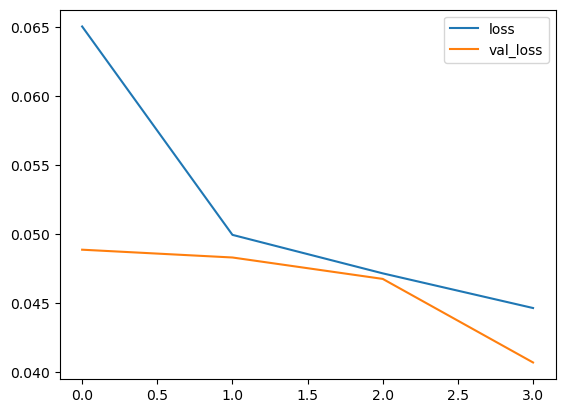

In [45]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [46]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [47]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [48]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 361ms/step


array([[0.998968  , 0.273492  , 0.97097856, 0.01271845, 0.85333437,
        0.07501652]], dtype=float32)

In [49]:
#(res > 0.5).astype(int)

In [50]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [51]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 36ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [52]:
res.shape

NameError: name 'res' is not defined

# 4. Evaluate Model

In [53]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [54]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [55]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


In [56]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8422160148620605, Recall:0.7031615972518921, Accuracy:0.4804413318634033


In [57]:
model.save('toxicity.h5')

/Users/aayushman/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 5. Test and Gradio

In [58]:
#!pip install gradio 

In [59]:
#import tensorflow as tf

In [60]:
#import gradio as gr

In [61]:
#interface = gr.Interface(fn=score_comment, 
                         #inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        #outputs='text')

In [62]:
#interface.launch(share=True)

In [63]:
#import tensorflow as tf

In [64]:
model = tf.keras.models.load_model('toxicity.h5')

In [65]:
input_str = vectorizer('You ass hole, dirty poop person')

In [66]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 1s 524ms/step


In [67]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [68]:
res

array([[0.9978558 , 0.23456153, 0.9039037 , 0.04442452, 0.8652482 ,
        0.15933031]], dtype=float32)

In [69]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text